## Prediciendo la diabetes usando algoritmo de árboles de decisión

Este conjunto de datos proviene originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. El objetivo es predecir en base a medidas diagnósticas si un paciente tiene o no diabetes.

Pregnancies. Número de embarazos del paciente (numérico)

Glucose. Concentración de glucosa en plasma a las 2 horas de un test de tolerancia oral a la glucosa (numérico)

BloodPressure. Presión arterial diastólica (medida en mmHg) (numérico)

SkinThickness. Grosor del pliegue cutáneo del tríceps (medida en mm) (numérico)

Insulin. Insulina sérica de 2 horas (medida en mu U/ml) (numérico)

BMI. Índice de masa corporal (numérico)

DiabetesPedigreeFunction. Función de pedigrí de diabetes (numérico)

Age. Edad del paciente (numérico)

Outcome. Variable de clase (0 o 1), siendo 0 negativo en diabetes y 1, positivo (numérico)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import DecisionTreeRegressor para regresion
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv')


In [3]:
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Revisión de nulos y duplicados

In [5]:
df.isnull().sum().sort_values(ascending=False)


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
# Eliminar duplicados / segunda forma
df_cleaned = df.drop_duplicates()

# Confirmar que ya no hay duplicados
print(f'Shape data set : {df.shape}')
print(f'Shape data set sin duplicados: {df_cleaned.shape}')

Shape data set : (768, 9)
Shape data set sin duplicados: (768, 9)


El data set no tiene valores nulos ni valores dupicados

In [9]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Revisión de valores en cero

Con el describe obtenemos valores de cero que no pueden ser lógicos para las columnas:

Glucose, no se puede tener nivel de glucosa en cero

BloodPressure, presión arterial de 0 sería para una persona fallecida

SkinThickness, grosor de la piel del tricep no puede ser cero

insulina los niveles de insulina no pueden ser cero absoluto

bmi indice de masa corporal en cero es imposible.


Se puede indicar que son valores faltantes que no se midieron y pusieron cero, por lo anteiror se procede a analizar las columnas para saber la cantidad de ceros que tiene cada una y así poder identificar que columnas eliminar y como tratar las que tienen valores minimos en cero.

In [10]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [11]:
# Columnas a revisar con cero
cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Contar valores iguales a 0 en cada columna
zeros_count = (df[cols] == 0).sum()

# Mostrar los resultados
print("Cantidad de ceros por columna:")
print(zeros_count)

Cantidad de ceros por columna:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


Se eliminan las columnas SkinThickness e insulina por la gran cantidad de ceros que tienen. Para las demás columnas se cuentan las filas para eliminarlas...

In [12]:
df.drop(columns=['SkinThickness', 'Insulin'],  inplace=True)

In [13]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [14]:
# Filas donde BloodPressure y BMI son 0
condicion_ambas = (df['BloodPressure'] == 0) & (df['BMI'] == 0)

# Contar cuántas filas cumplen ambas condiciones
total_ambas = df[condicion_ambas].shape[0]

print(f"Número de filas con BloodPressure = 0 y BMI = 0: {total_ambas}")
# Número de filas con BloodPressure = 0 y BMI = 0: 7

Número de filas con BloodPressure = 0 y BMI = 0: 7


In [15]:
condicion = (df['BloodPressure'] == 0) | (df['BMI'] == 0) | (df['Glucose'] == 0)
filas_a_eliminar = df[condicion].shape[0]

print(f"Total de filas que tienen cero en BloodPressure, BMI o Glucose: {filas_a_eliminar}")
# Total de filas que tienen cero en BloodPressure, BMI o Glucose: 44

Total de filas que tienen cero en BloodPressure, BMI o Glucose: 44


El total de filas que se eliminarian seria de : 44

In [16]:
# La condición para filas con ceros en esas columnas
condicion = (df['BloodPressure'] == 0) | (df['BMI'] == 0) | (df['Glucose'] == 0)

# Obtener los índices de las filas a eliminar
indices_a_eliminar = df.loc[condicion].index

# Eliminar esas filas directamente en df
df.drop(indices_a_eliminar, inplace=True)

print(f"Filas restantes después de eliminar: {len(df)}")
# Filas restantes después de eliminar: 724

Filas restantes después de eliminar: 724


In [17]:
df.describe()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,3.866022,121.882597,72.400552,32.467127,0.474765,33.350829,0.343923
std,3.362803,30.750030,12.379870,6.888941,0.332315,11.765393,0.475344
min,0.000000,44.000000,24.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,27.500000,0.245000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,32.400000,0.379000,29.000000,0.000000
75%,6.000000,142.000000,80.000000,36.600000,0.627500,41.000000,1.000000
max,17.000000,199.000000,122.000000,67.100000,2.420000,81.000000,1.000000


Ahora se realiza analisis univariado, multivariado y correlación de las variables numéricas

In [18]:
var_categoricas = []
var_numericas= []

for col in df.columns:
    if df[col].dtype == 'object':
        var_categoricas.append(col)
    elif pd.api.types.is_numeric_dtype(df[col]):
        var_numericas.append(col)

print("Variables categóricas:")
print(var_categoricas)

print("\n")
print("Variables numéricas:")
print(var_numericas)

Variables categóricas:
[]


Variables numéricas:
['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


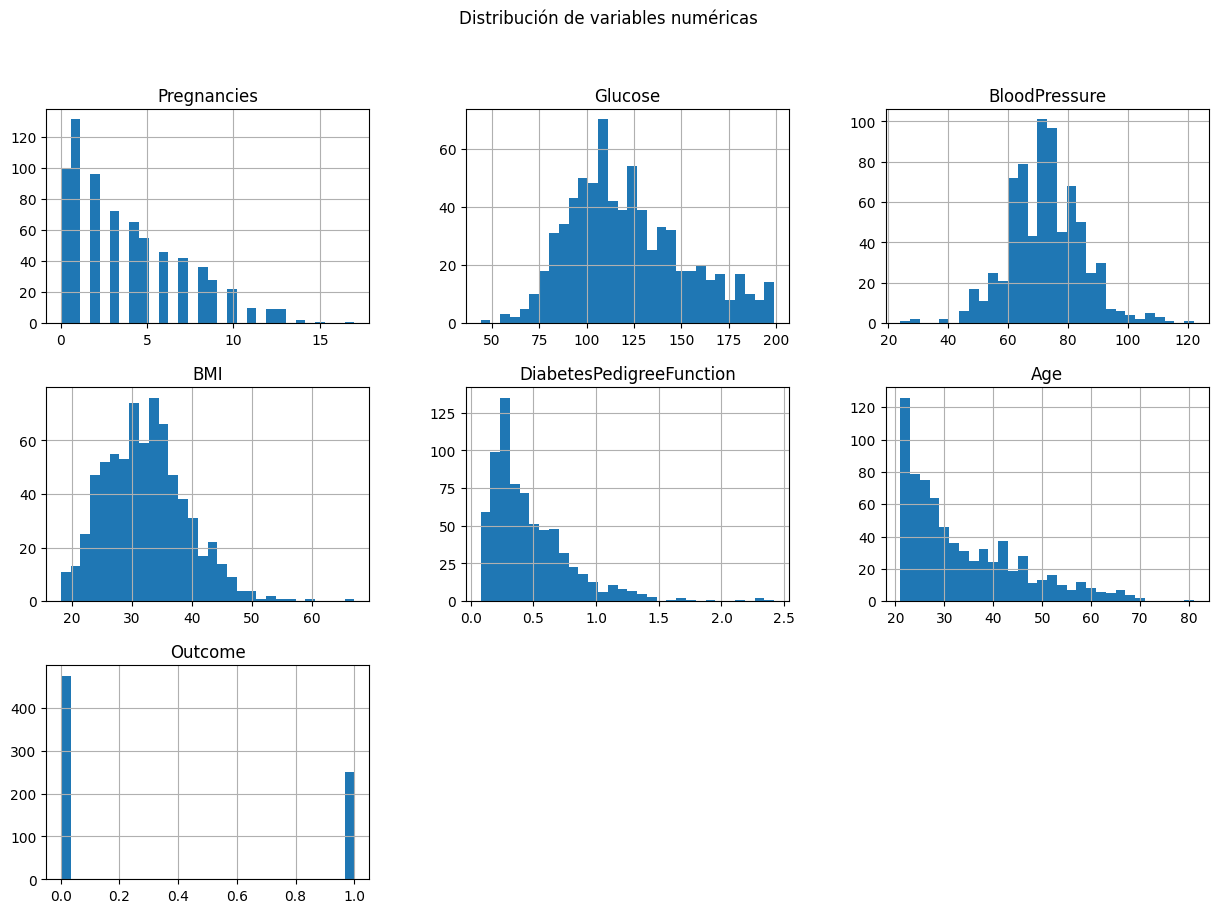

In [19]:
df[var_numericas].describe().T
df[var_numericas].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribución de variables numéricas")
plt.show()


Embarazos ( Pregnancies ):

La personas que nunca han tenido embarazos han sido cerca de 100, y al rededor de 230 personas han tenido entre 1 y 2 embarazos, a partir de los 8 embarazos la frecuencia cae por debajo de las 40 personas, y entre 10 y 17 embarazos se registran al rededor de 54 personas.

Presión arterial (BloodPressure):

La mayoria de personas tiene una presión arterial en el rango de los 63 a 83 mmgh lo que puede considerarse como una presión normal, los datos menores a 60 o mayores a 83 podrían considerarse de alto riesgo, aunque se requeriría información médica para confirmarlo.

Índice de masa corporta (BMI):

La mayoria de personas tienen un valor de indice de masa corporal (BMI) entre los 25 y 38, lo que podría indicar que prevalece cierto tipo de obsesidad en el conjunto de datos.

Age

La mayoria de personas estan entre los 22 y 29 años lo que indica que en el dataset predominan los jovenes.

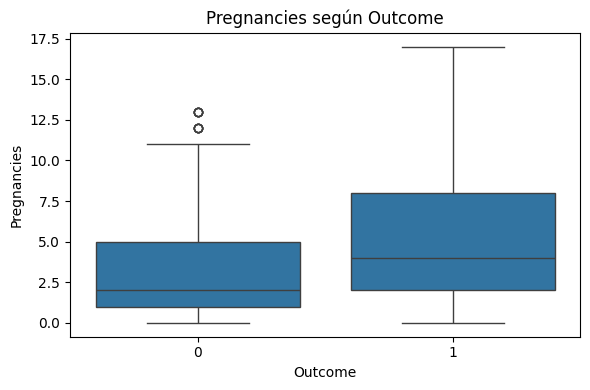

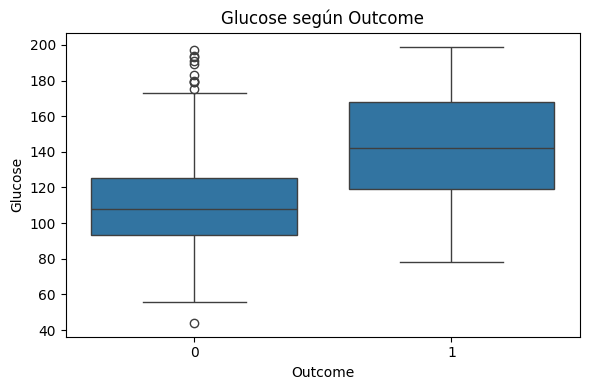

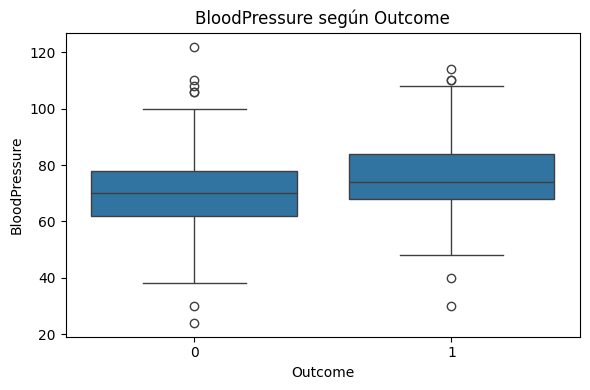

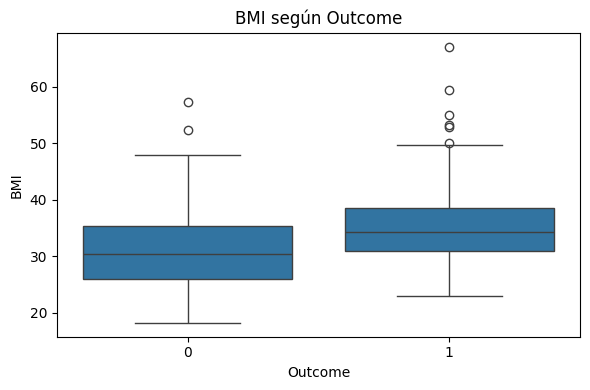

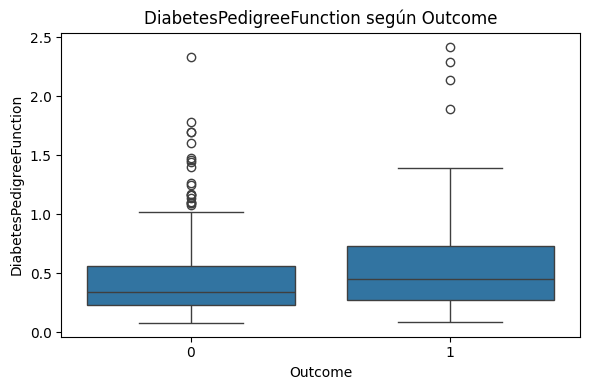

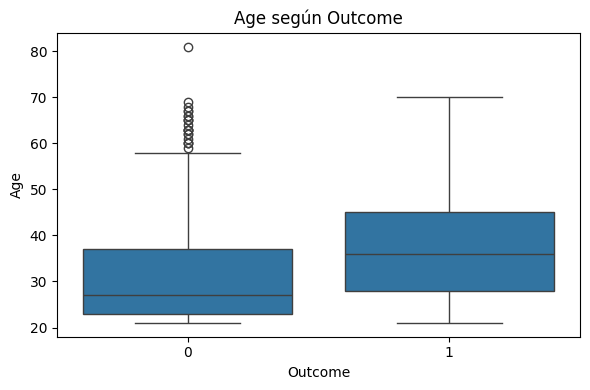

In [20]:
for col in ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Outcome', y=col, data=df)
    plt.title(f'{col} según Outcome')
    plt.tight_layout()
    plt.show()

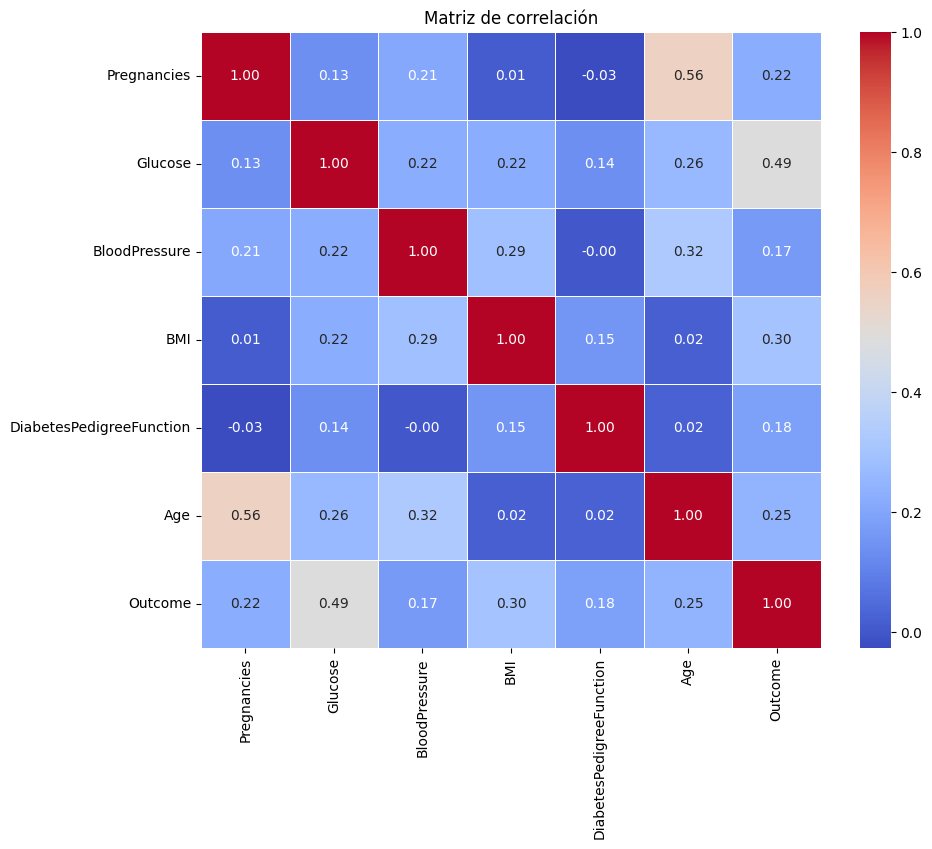

In [21]:
import numpy as np

plt.figure(figsize=(10, 8))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

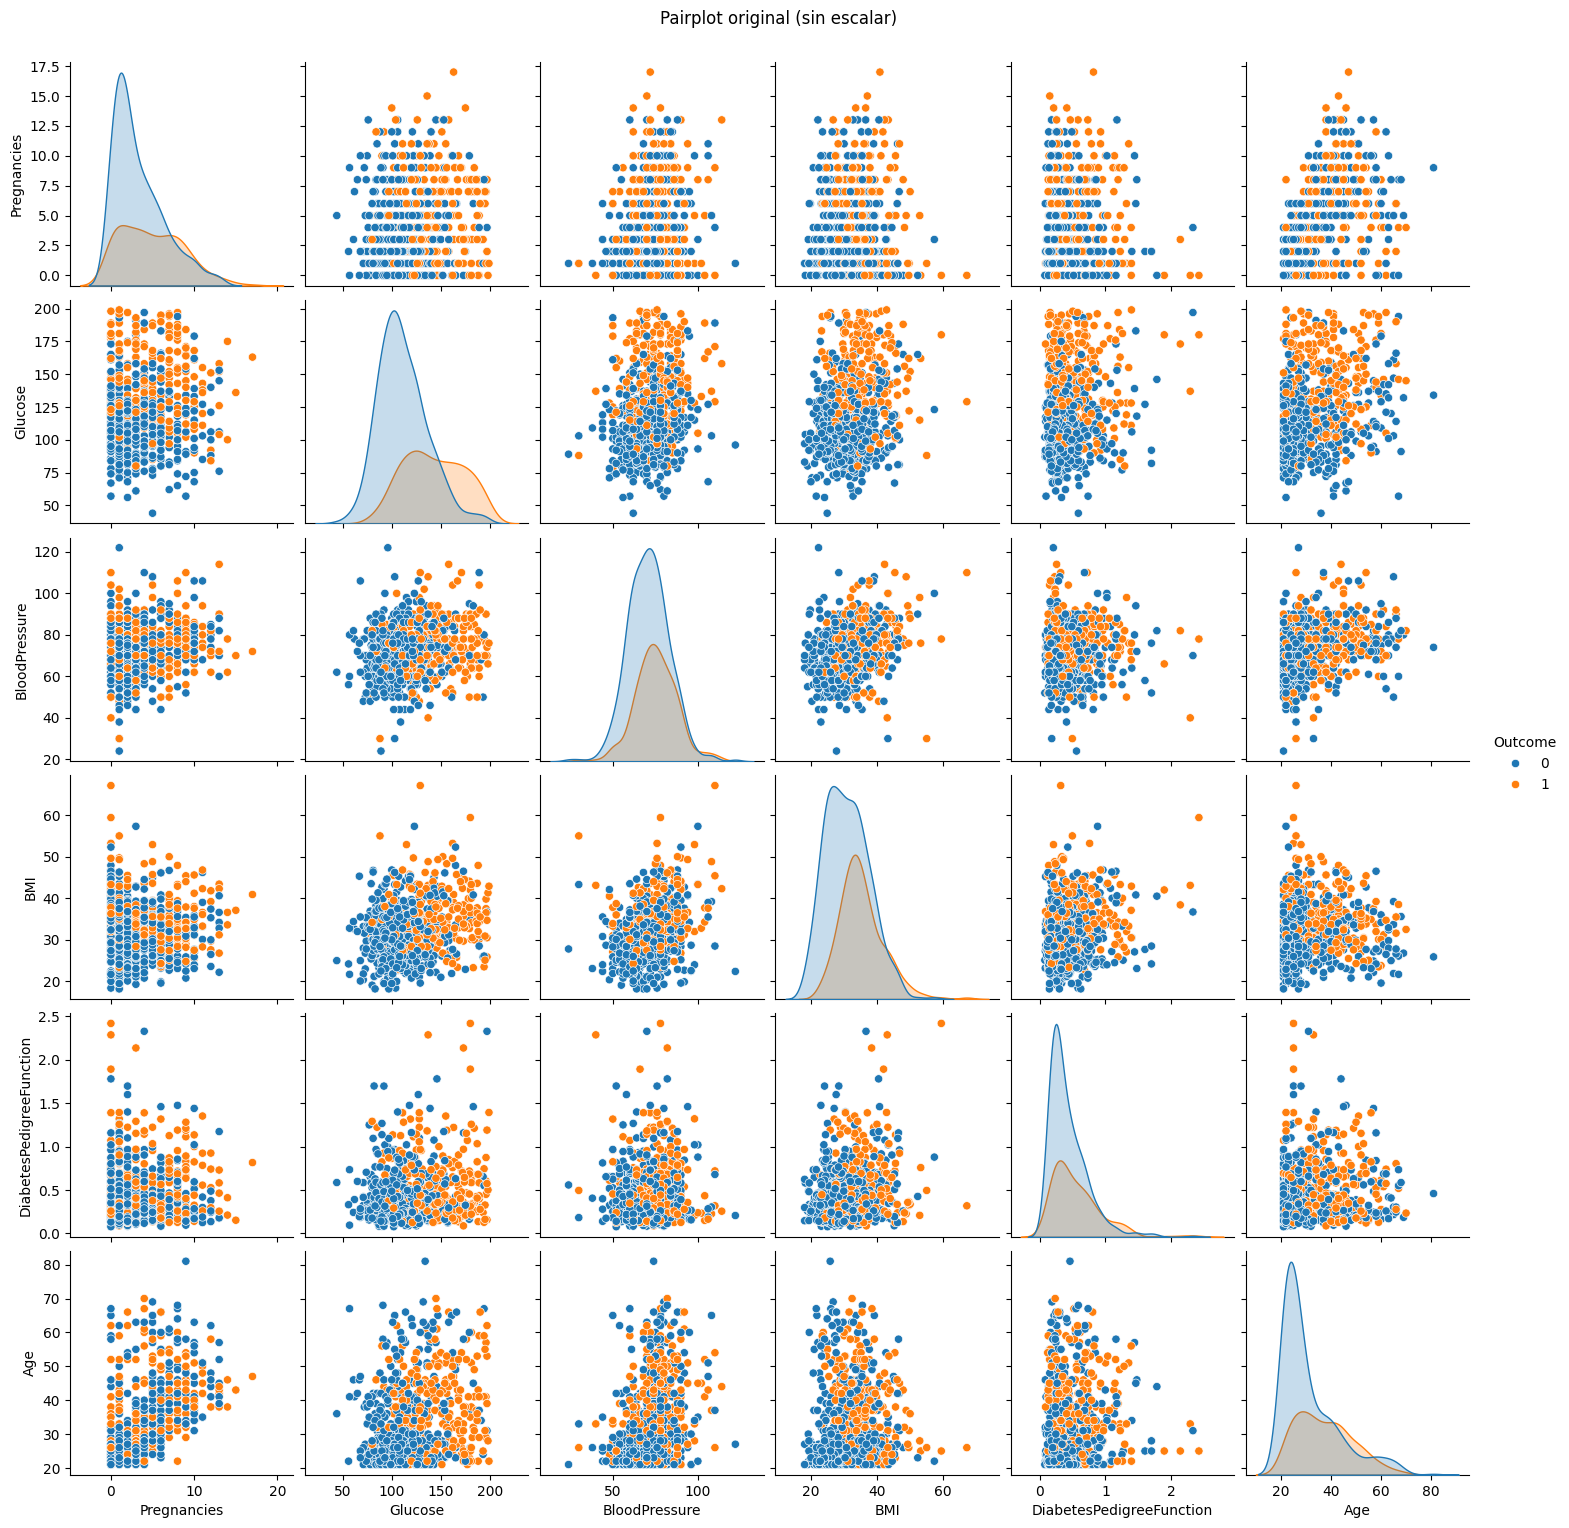

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot con los datos originales (sin escalar)
sns.pairplot(df, hue='Outcome', diag_kind='kde')
plt.suptitle("Pairplot original (sin escalar)", y=1.02)
plt.show()

Se puede identififcar que no hay fuertes corelaciones lineales, los datos están mezclados y esto puede indicar que el tener diabetes no depende de una o dos variables si no más bien de una combinación de más variables.

Estandarización para correlación

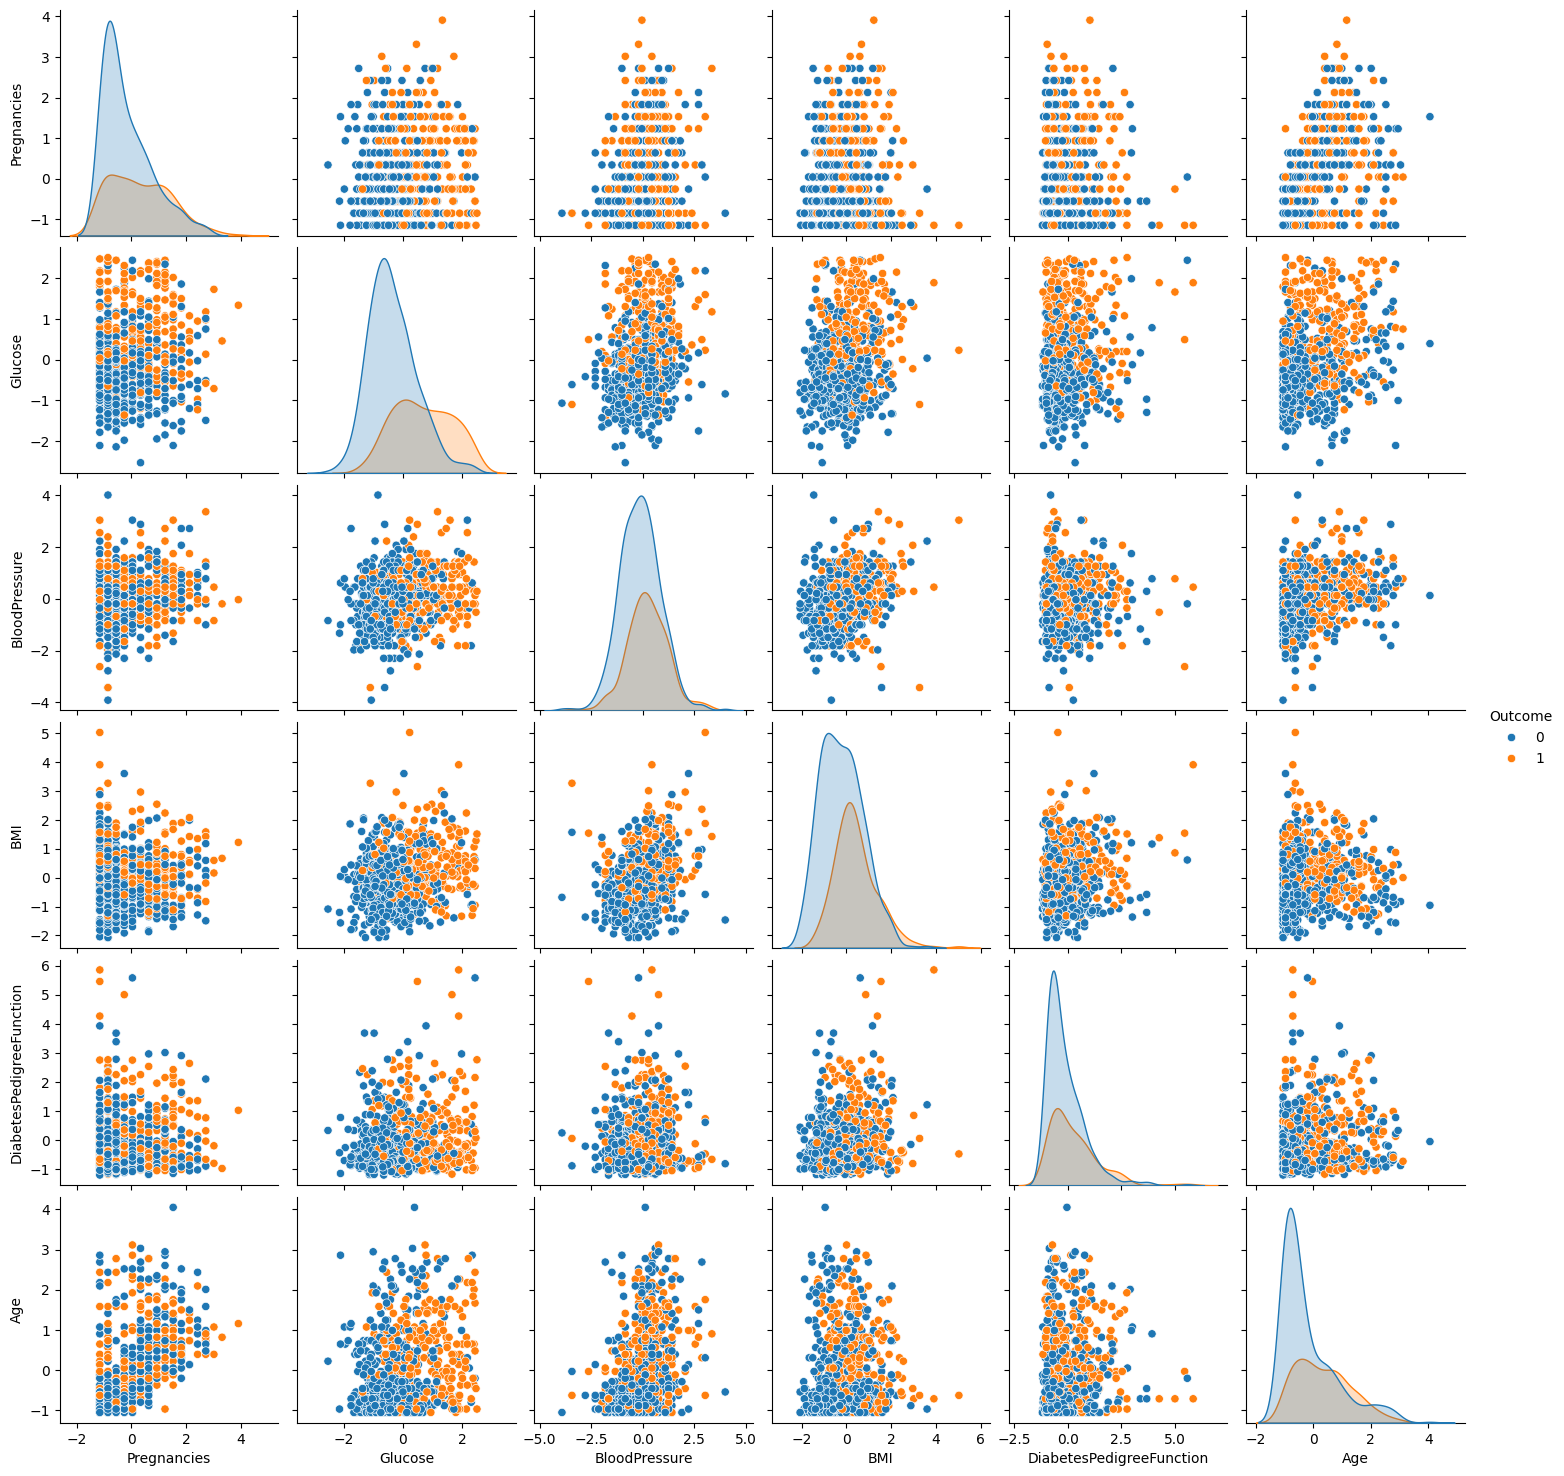

In [23]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Selección de columnas numéricas (excepto Outcome)
cols_to_scale = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Escalado
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[cols_to_scale]), columns=cols_to_scale)

# Agregar columna Outcome sin escalar
df_scaled['Outcome'] = df['Outcome'].values

# Pairplot escalado
sns.pairplot(df_scaled, hue='Outcome')


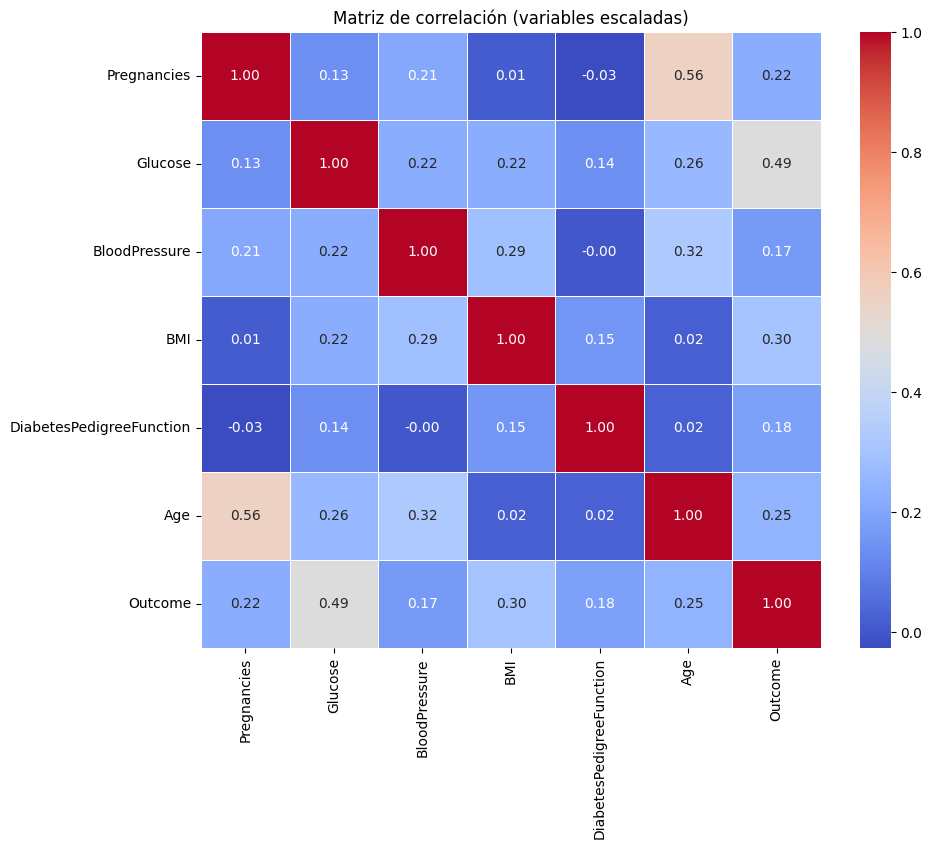

In [24]:
# Calcular la matriz de correlación sobre el dataframe escalado
correlation_matrix = df_scaled.corr()

# Dibujar el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlación (variables escaladas)')
plt.show()

Entrenamiento del modelo

In [25]:
# Separar variables sin escalar
X_sin = df.drop('Outcome', axis=1)
y_sin = df['Outcome']

# Dividir en conjunto de entrenamiento y prueba
X_train_sin, X_test_sin, y_train_sin, y_test_sin = train_test_split(X_sin, y_sin, test_size=0.2, random_state=42)

# Mostrar tamaños de los subconjuntos
print("Tamaño X_train:", X_train_sin.shape)
print("Tamaño X_test:", X_test_sin.shape)
print("Tamaño y_train:", y_train_sin.shape)
print("Tamaño y_test:", y_test_sin.shape)

Tamaño X_train: (579, 6)
Tamaño X_test: (145, 6)
Tamaño y_train: (579,)
Tamaño y_test: (145,)


In [26]:
# Separar variables escaladas
X = df_scaled.drop('Outcome', axis=1)
y = df_scaled['Outcome']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mostrar tamaños de los subconjuntos
print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test:", X_test.shape)
print("Tamaño y_train:", y_train.shape)
print("Tamaño y_test:", y_test.shape)

Tamaño X_train: (579, 6)
Tamaño X_test: (145, 6)
Tamaño y_train: (579,)
Tamaño y_test: (145,)


Inicialización y entrenamiento del modelo

In [27]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# model = DecisionTreeRegressor()
# model.fit(X_train, y_train)

In [28]:
list(X_train.columns)

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

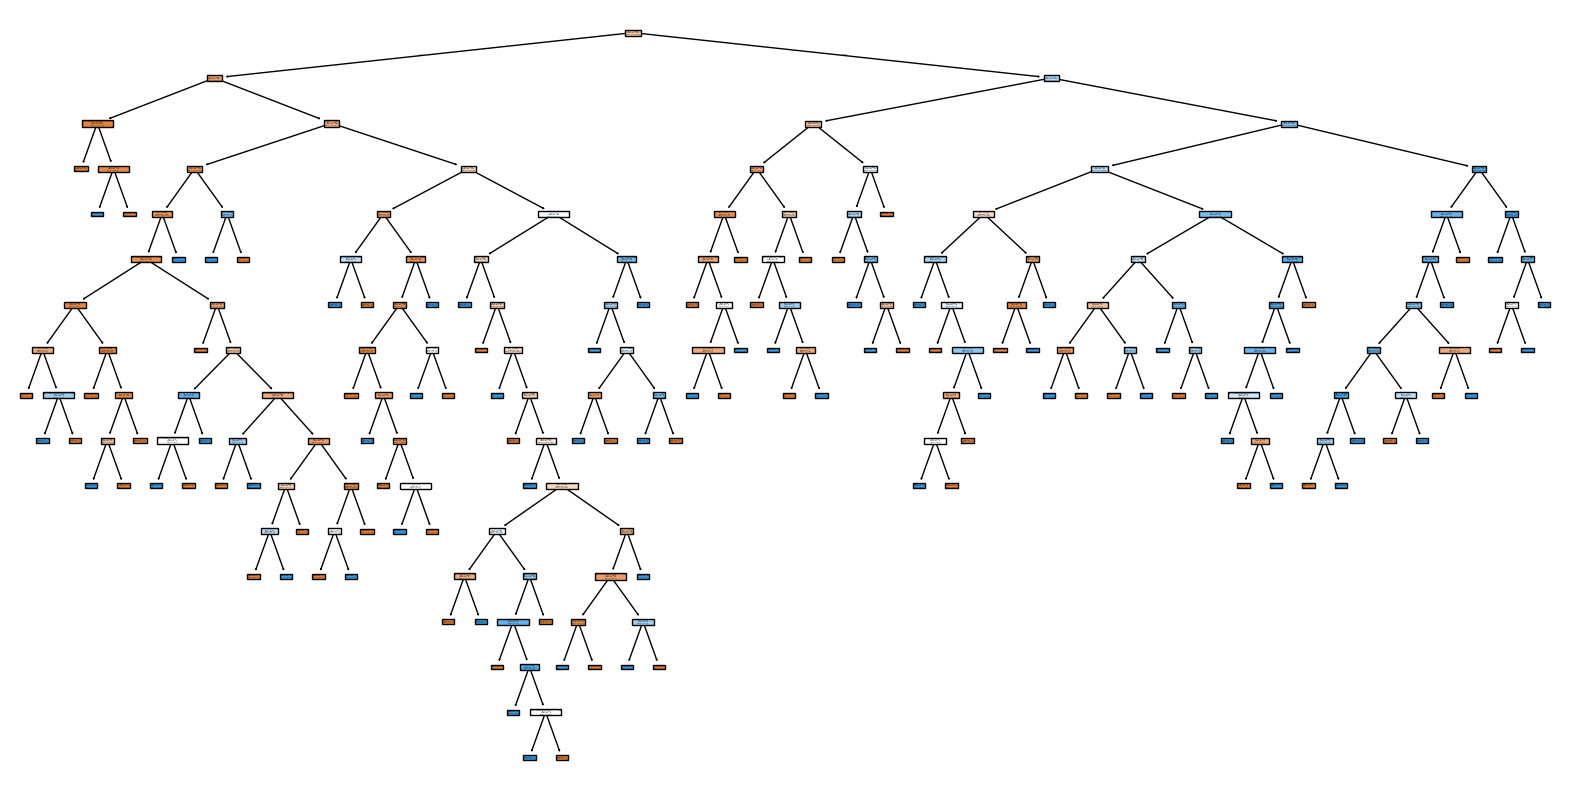

In [29]:
fig = plt.figure(figsize=(20,10))
tree.plot_tree(model, feature_names = list(X_train.columns), filled = True)

plt.show()

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))
print("\nExactitud (accuracy):", accuracy_score(y_test, y_pred))

Matriz de confusión:
 [[79 23]
 [11 32]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.88      0.77      0.82       102
           1       0.58      0.74      0.65        43

    accuracy                           0.77       145
   macro avg       0.73      0.76      0.74       145
weighted avg       0.79      0.77      0.77       145


Exactitud (accuracy): 0.7655172413793103


In [31]:
### Profundidad del árbol
model.get_depth()

16

In [32]:
### Número de hojas
model.get_n_leaves()

np.int64(108)

## Optimización con búsqueda de hiperparámetros

In [33]:
# Optimización de la profundidad del árbol, elegir un hiperpárametro que mejore el modelo
lista_treer_train = []
lista_treer_test = []

# Definimos la lista de valores de max_depth que a explorar
max_depths = [1,2,3,4,5,6,7,8,9,10,11,12,13]

for item in max_depths:

    model_tree = DecisionTreeClassifier(max_depth = item, random_state=42)

    model_tree.fit(X_train,y_train)

    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = model_tree.predict(X_train)
    train_tree_ac = accuracy_score(y_train, y_train_pred)


    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = model_tree.predict(X_test)
    test_tree_ac = accuracy_score(y_test, y_test_pred)

    # Agregar la información a las listas
    lista_treer_train.append(train_tree_ac)
    lista_treer_test.append(test_tree_ac)

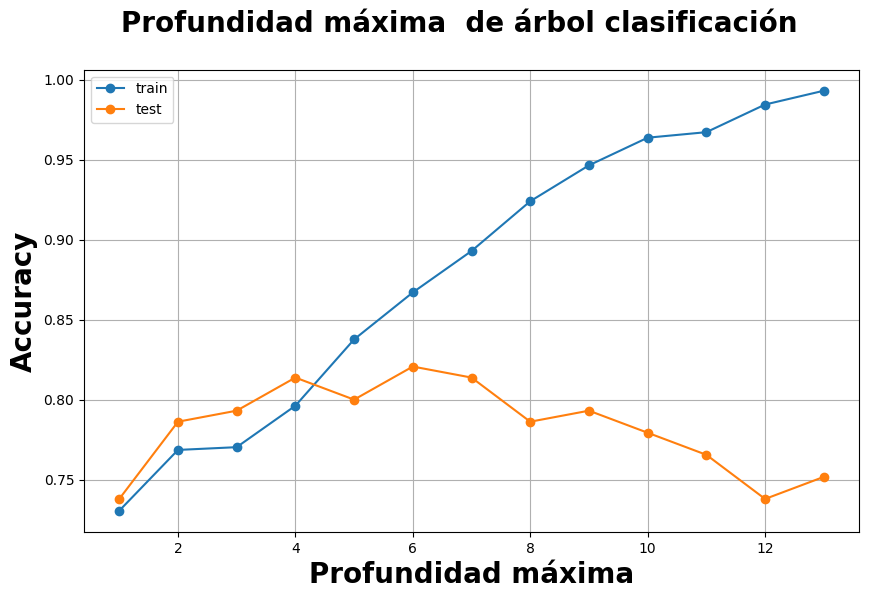

In [34]:
### Gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.suptitle('Profundidad máxima  de árbol clasificación' , fontweight = 'black', fontsize=20)
plt.plot(max_depths,lista_treer_train,'o-',label='train' )
plt.plot(max_depths,lista_treer_test,'o-',label='test')
plt.grid(True)
plt.legend()
plt.xlabel('Profundidad máxima',fontsize=20,fontweight = 'black')
plt.ylabel('Accuracy',fontsize=20,fontweight = 'black');

Es importante garantizar una buena accuaracy sin llegar al sobreajuste, por lo tanto inicialmente seleccionamos unos valores para el parametro max_depth entre 3 y 6.

# Grid Search

In [35]:
from sklearn.metrics import f1_score

# Definir los parámetros para probar
param_grid = {
    'max_depth': [3,4,5,6,None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Usamos DecisionTreeClassifier en lugar de DecisionTreeRegressor
tree_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',  # Usamos una métrica de clasificación para dataset desbalanceado
    verbose=1,
    n_jobs=-1
)

# Entrenar con búsqueda en malla
tree_grid.fit(X_train, y_train)

# Ver el mejor modelo y puntaje
print("Mejores parámetros:", tree_grid.best_params_)
print("Mejor precisión (accuracy):", tree_grid.best_score_)



Fitting 5 folds for each of 135 candidates, totalling 675 fits
Mejores parámetros: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor precisión (accuracy): 0.6283342871001674


In [36]:
best_tree = tree_grid.best_estimator_ # se obtiene el nuevo modelo

y_pred_two = best_tree.predict(X_test)
print("\nExactitud (accuracy):", f1_score(y_test, y_pred_two))


Exactitud (accuracy): 0.6666666666666666


# Optimización de hiperparametros usando RandomSearchCV

In [37]:
from scipy.stats import randint
# Definir el espacio de búsqueda con distribuciones aleatorias
param_dist = {
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones a probar
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Ajustar modelo
random_search.fit(X_train, y_train)

# Resultados
print("Mejores parámetros (Random):", random_search.best_params_)
print("Mejor f1_score promedio:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros (Random): {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5}
Mejor f1_score promedio: 0.6283342871001674


In [38]:
best_tree_two = random_search.best_estimator_ # se obtiene el nuevo modelo

y_pred_three = best_tree_two.predict(X_test)
print("\n Mejor f1_score promedio:", f1_score(y_test, y_pred_three))


 Mejor f1_score promedio: 0.6666666666666666


# Optimización de hiperparametros usando BayesSearchCV

In [ ]:
# !pip install scikit-optimize

In [39]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from sklearn.tree import DecisionTreeClassifier

# Definir el espacio de búsqueda
param_space = {
    'max_depth': Categorical([3, 5, 10, 20, None]),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4),
    'max_features': Categorical([None, 'sqrt', 'log2'])
}

# Configurar BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    search_spaces=param_space,
    n_iter=50,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Ajustar el modelo
bayes_search.fit(X_train, y_train)

# Resultados
print("Mejores parámetros (Bayesian):", bayes_search.best_params_)
print("Mejor f1_score promedio:", bayes_search.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/home/vscode/.local/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.str_('log2'), np.int64(1), np.int64(3)] before, using random point [None, 'log2', np.int64(3), np.int64(2)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/vscode/.local/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.str_('log2'), np.int64(1), np.int64(2)] before, using random point [5, 'sqrt', np.int64(2), np.int64(7)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores parámetros (Bayesian): OrderedDict([('max_depth', 5), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 7)])
Mejor f1_score promedio: 0.6470503642007082


In [40]:
best_four = bayes_search.best_estimator_ # se obtiene el nuevo

y_pred_four = best_four.predict(X_test)
print("\nMejor f1_score promedio:", f1_score(y_test, y_pred_four))


Mejor f1_score promedio: 0.6185567010309279


# Conclusiones
## Metrica f1 con los 3 metodos de optimización:
Grid Search:
Mejores parámetros encontrados:

max_depth=5, max_features='sqrt', min_samples_leaf=1, min_samples_split=2

F1 promedio en validación cruzada: 0.6283 Accuracy en conjunto de prueba: 0.6667

Random Search:
Mejores parámetros encontrados: max_depth=5, max_features='log2', min_samples_leaf=1, min_samples_split=2

F1 promedio en validación cruzada: 0.6283 Accuracy en conjunto de prueba: 0.6667

Bayes search
Mejores parámetros encontrados: max_depth=5, max_features='sqrt', min_samples_leaf=2, min_samples_split=7

F1 promedio en validación cruzada: 0.6471

Accuaracy en conjunto de prueba: 0.6186


## Conclusiones final: Grid Search y Random Search lograron el mejor F1-score en el conjunto de prueba (0.6667)



## Metrica accuaracy con los 3 metodos de optimización (Otras pruebas realizadas)
Los 3 metodos de optimización dan como resultado un valor en común para un max_depth = 5 y un alto valor de min_samples_split=10 lo que indica que un árbol poco profundo y sin tanta ramas puede generalizar mejor los datos nuevos.

En el caso de la optimización bayes search obtuvo un mejor rendimiento en promedio con los otros métodos de optimización de hiperparametros pero utilizando la metrica de accuaracy en los metodos de busqueda hiperparametrización por lo que no se tuvo en cuenta y se volvió a realizar el ejercicio usando el f1 para dataset balanceado.

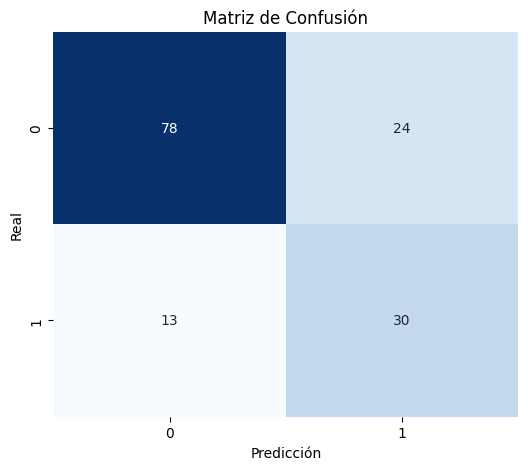

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       102
           1       0.56      0.70      0.62        43

    accuracy                           0.74       145
   macro avg       0.71      0.73      0.71       145
weighted avg       0.77      0.74      0.75       145



In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_four)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de métricas
print(classification_report(y_test, y_pred_four))

Para la métrica de accuaracy, de todas las predicción que el modelo hizo para la clase 0, el 86% fueron correctas y de las predicciones hechas como clase 1 solo el 56% fueron correctas.